# LJ Potential Benchmarking

Benchmarking TMol LJ-potential implementation.

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first, merge

In [3]:
import numba
import numba.cuda

numba.config.NUMBA_NUM_THREADS = 8

In [4]:
import tmol.tests.data

In [5]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

from tmol.tests.benchmark import make_fixture, make_subfixture, stat_frame, subfixture

In [6]:
import tmol.score

In [7]:
import torch

In [8]:
import functools

In [25]:
import tmol.score.ljlk.numba_potential

def benchmark_decoys():
    stats = []
    
    for n, d in decoys.items():
        fixture = make_fixture("lj", stats.append, nres=len(d.tmol_system.residues), natoms=len(d.tmol_coords), model=n)
            
        logging.info(f"{n}")
        
        score_graph = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system)

        ljlk_resolver = score_graph.param_resolver
        ljlk_atom_types = ljlk_resolver.type_idx(score_graph.atom_types)

        coords = score_graph.coords.detach()[0]
        types = torch.tensor(ljlk_atom_types[0])
        path_length = torch.tensor(score_graph.bonded_path_length[0].astype("u1"))
        
        coords_c = coords.cuda()
        types_c = types.cuda()
        path_length_c = path_length.cuda()

        ljlk_resolver_c = ljlk_resolver.from_database(score_graph.ljlk_database, device=torch.device("cuda"))
        
        @subfixture(fixture, platform="cpu")
        def cpu_serial():
            return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                coords,
                types,
                path_length,

                ljlk_resolver.pair_params.lj_sigma,
                ljlk_resolver.pair_params.lj_switch_slope,
                ljlk_resolver.pair_params.lj_switch_intercept,
                ljlk_resolver.pair_params.lj_coeff_sigma12,
                ljlk_resolver.pair_params.lj_coeff_sigma6,
                ljlk_resolver.pair_params.lj_spline_y0,
                ljlk_resolver.pair_params.lj_spline_dy0,

                ljlk_resolver.global_params.lj_switch_dis2sigma,
                ljlk_resolver.global_params.spline_start,
                ljlk_resolver.global_params.max_dis,
                parallel=False,
            ).sum()
            
        @subfixture(fixture, platform="cpu")
        def cpu_parallel():
            return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                coords,
                types,
                path_length,

                ljlk_resolver.pair_params.lj_sigma,
                ljlk_resolver.pair_params.lj_switch_slope,
                ljlk_resolver.pair_params.lj_switch_intercept,
                ljlk_resolver.pair_params.lj_coeff_sigma12,
                ljlk_resolver.pair_params.lj_coeff_sigma6,
                ljlk_resolver.pair_params.lj_spline_y0,
                ljlk_resolver.pair_params.lj_spline_dy0,

                ljlk_resolver.global_params.lj_switch_dis2sigma,
                ljlk_resolver.global_params.spline_start,
                ljlk_resolver.global_params.max_dis,
            ).sum()
            
                
        inputs = dict(
            atom_types = types_c,
            bonded_path_length = path_length_c,
        )
        preorg_inputs = {n : numba.cuda.as_cuda_array(p) for n, p in inputs.items() }
        
        params = dict(
         lj_sigma=           ljlk_resolver_c.pair_params.lj_sigma,
         lj_switch_slope=           ljlk_resolver_c.pair_params.lj_switch_slope,
         lj_switch_intercept=           ljlk_resolver_c.pair_params.lj_switch_intercept,
         lj_coeff_sigma12=           ljlk_resolver_c.pair_params.lj_coeff_sigma12,
         lj_coeff_sigma6=           ljlk_resolver_c.pair_params.lj_coeff_sigma6,
         lj_spline_y0=           ljlk_resolver_c.pair_params.lj_spline_y0,
         lj_spline_dy0=           ljlk_resolver_c.pair_params.lj_spline_dy0,
            
          lj_switch_dis2sigma=          ljlk_resolver_c.global_params.lj_switch_dis2sigma,
          spline_start=          ljlk_resolver_c.global_params.spline_start,
          max_dis=          ljlk_resolver_c.global_params.max_dis,
        )
        
        preorg_params = {n : numba.cuda.as_cuda_array(p) for n, p in params.items() }
        
        
        @subfixture(fixture, platform="cuda")
        def cuda():
            try:
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords = coords_c,
                    **merge(inputs, params)
                ).sum()
            finally:
                torch.cuda.synchronize()
        
        @subfixture(fixture, platform="cuda")
        def cuda_preorg_params():
            try:
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords = coords_c,
                    **merge(inputs, preorg_params)
                ).sum()
            finally:
                torch.cuda.synchronize()
                
        @subfixture(fixture, platform="cuda")
        def cuda_preorg_all():
            try:
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords = coords_c,
                    **merge(preorg_inputs, preorg_params)
                ).sum()
            finally:
                torch.cuda.synchronize()
            
        logging.info(f"cpu_serial: {cpu_serial} cpu_parallel: {cpu_parallel} cuda: {cuda} cuda_preorg_all: {cuda_preorg_all}")
        
    return stats

In [26]:
decoys = tmol.tests.data.structures_bysize()

In [27]:
import importlib
importlib.reload(tmol.score.ljlk.numba_potential)

res = benchmark_decoys()

INFO:root:BYSIZE_400_RES_6AZU
INFO:root:cpu_serial: -84.50553131103516 cpu_parallel: -84.50553131103516 cuda: -84.50548553466797 cuda_preorg_all: -84.50548553466797
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:cpu_serial: -9.240137100219727 cpu_parallel: -9.240137100219727 cuda: -9.24010181427002 cuda_preorg_all: -9.24010181427002
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:cpu_serial: -154.1009063720703 cpu_parallel: -154.1009063720703 cuda: -154.1009063720703 cuda_preorg_all: -154.1009063720703
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:tmol.system.io.ResidueReader:missing atoms in input: {'HG'}
INFO:root:BYSIZE_300_RES_6F8B
INFO:root:cpu_serial: -214.80563354492188 cpu_parallel: -214.80563354492188 cuda: -214.80560302734375 cuda_preorg_all: -214.80560302734375
INFO:root:BYSIZE_100_RES_5UMR
INFO:root:cpu_serial: -78.01646423339844 cpu_par

In [32]:
import pandas
import seaborn
from matplotlib import pyplot

In [33]:
dat = stat_frame(res)

dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'lj.cpu_serial'").groupby("nres").time.mean().rename("serial_cpu_mean").to_frame(),
            left_on="nres",
            right_index=True
        ).eval("time / serial_cpu_mean").rename("serial_cpu_relative")
    ),
    axis=1
)

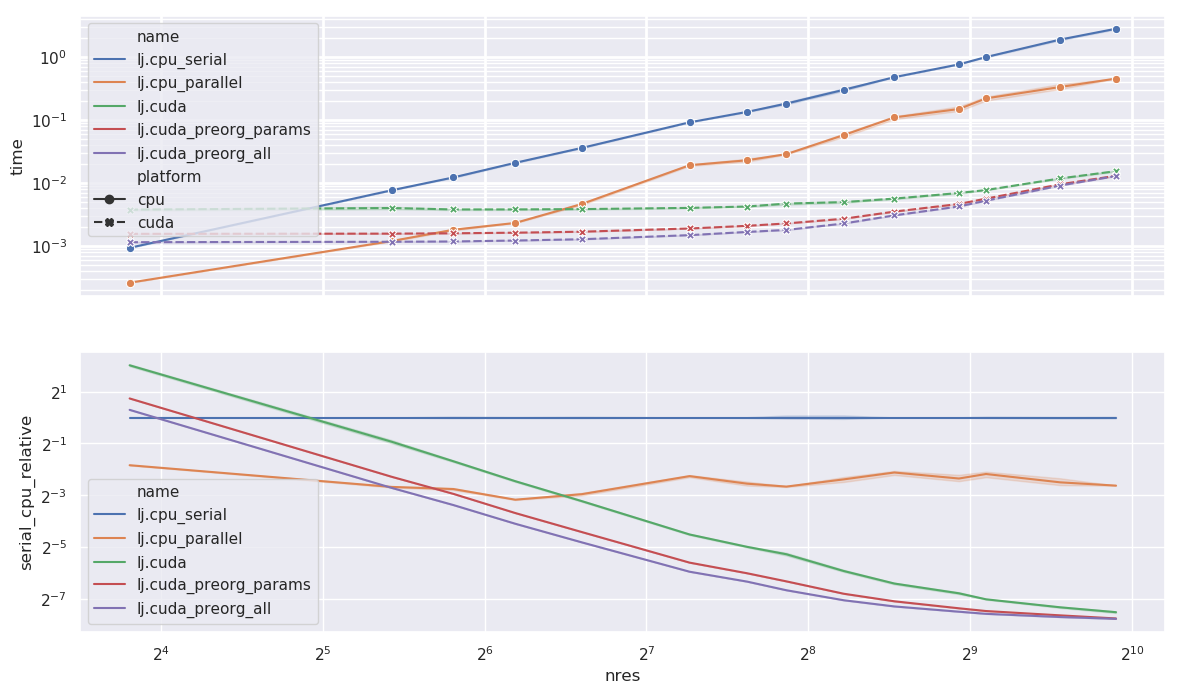

In [34]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", style="platform", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "serial_cpu_relative", data=dat, hue="name", markers=True)

In [35]:
(
    dat.query("name=='lj.cuda_preorg_all'")
    .groupby("nres")[["serial_cpu_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

mean                           max            \
     serial_cpu_relative      time serial_cpu_relative      time   
nres                                                               
14              1.227423  0.001144            2.767310  0.002580   
43              0.152218  0.001163            0.187332  0.001431   
56              0.096224  0.001175            0.127184  0.001553   
73              0.058354  0.001217            0.065253  0.001360   
97              0.035516  0.001275            0.072509  0.002603   
154             0.016175  0.001482            0.025972  0.002379   
197             0.012415  0.001665            0.013991  0.001877   
233             0.009860  0.001791            0.017383  0.003158   
298             0.007542  0.002267            0.014098  0.004237   
370             0.006393  0.003051            0.009376  0.004474   
488             0.005552  0.004228            0.005700  0.004341   
548             0.005245  0.005222            0.005368  0.005345   
753             0.004814  0.009089            0.004897  0.009246   
956             0.004590  0.012867            0.004598  0.012890   

                     std            
     serial_cpu_relative      time  
nres                                
14              0.093030  0.000087  
43              0.004488  0.000034  
56              0.002052  0.000025  
73              0.001337  0.000028  
97              0.002411  0.000087  
154             0.000549  0.000050  
197             0.000181  0.000024  
233             0.000441  0.000080  
298             0.000361  0.000109  
370             0.000198  0.000095  
488             0.000031  0.000024  
548             0.000022  0.000022  
753             0.000015  0.000027  
956             0.000003  0.000008